# HSMMのrobust性の検証
+ As the true distribution $q(x)$, we consider the following distribution:  
$q(x) = \sum_{k=1}^{K^*} (a_k - \delta_k) N(x|b_k, s_k) + \delta_k Cauchy(x|b_k)$,  
where we restrict $a_k$ and $\delta_k$ that $q(x)$ is a distribution.

# Estimation for Hyperbolic Secant Mixture model(HSMM)
+ To estimate the HSMM, we use the local variational approximation method to approximate bayesian posterior distribution.
+ Learning model:
    + $p(x|w) = \sum_{k=1}^K a_k \frac{\sqrt{s_k}}{2} \frac{1}{\cosh(\frac{s_k}{2}(x - b_k))}$
    + $x, b_k \in \mathbb{R}, s_k \in \mathbb{R}_+$
+ Prior distribution:
    + $\varphi(w) = Dir(a|\{ \alpha_k \}_{k=1}^K) \prod_{k=1}^K N(b_k|0, (s_k \beta_k)^{-1} ) Gam(s_k|\gamma_k, \delta_k)$
+ Algorithm:
   1. Initialize the following variables:
       + $g_{ik}(\eta), v_{ik}(\eta), h_{ik}(\xi), u_{ik}(\xi)$
   2. Update the approximated posterior distribution:
       + $\hat{\alpha}_k = \alpha_k + \sum_{i=1}^n u_{ik}(\xi)$
       + $\hat{\beta}_k = \beta_k + \sum_{i=1}^n -2v_{ik}(\eta)$
       + $\hat{m}_k = \frac{1}{\hat{\beta}_k} \sum_{i=1}^n -2v_{ik}(\eta)x_i$
       + $\hat{\gamma}_k = \gamma_k + \frac{1}{2}\sum_{i=1}^n u_{ik}(\xi)$
       + $\hat{\delta}_k = \delta_k + \sum_{i=1}^n -v_{ik}(\eta)x_i^2 - \frac{\hat{\beta}_k}{2}\hat{m}_k^2$
   3. Update the auxililary variables for log cosh term.
       + $g_{ik}(\eta) = \frac{\hat{\gamma}_k}{\hat{\delta}_k} (x_i - \hat{m}_k)^2 + \frac{1}{\hat{\beta}_k}$
       + $v_{ik}(\eta) = -u_{ik}(\xi)\frac{ \tanh(\sqrt{g_{ik}(\eta)}/2) }{4\sqrt{g_{ik}(\eta)}}$
   4. Update the auxililary variables for mixture term
       + $h_{ik}(\xi) = \psi(\hat{\alpha}_k) - \psi(\sum_{l=1}^K \hat{\alpha}_l) + \frac{1}{2}(\psi(\hat{\gamma}_k) - \log(\hat{\delta}_k)) - \log(\cosh(\sqrt{g_{ik}(\eta)}/2)) $
       + $u_{ik}(\xi) = \frac{ \exp(h_{ik}(\xi)) }{ \sum_{l=1}^K \exp(h_{il}(\xi)) }$  
       where ,$\psi(x) = \frac{d}{dx}\log \Gamma(x)$
   5. Return back to 2.
   
+ Evaluation function $\overline{F}_{\xi, \eta}(x^n)$:
    + $\overline{F}_{\xi, \eta}(x^n) = - \phi(h(\xi)) - \psi(g(\eta)) + u(\xi) \cdot h(\xi) + v(\eta) \cdot g(\eta) $  
        $+ n \log 2 \pi + \log \Gamma(\sum_{l = 1}^K \hat{\alpha}_l) - \log \Gamma({\sum_{l = 1}^K\alpha}_l) + \sum_{k=1}^K \log \frac{\Gamma(\alpha_k)}{\Gamma(\hat{\alpha}_k)}$  
        $+ \sum_{k=1}^K \bigl\{ \frac{1}{2} \log \frac{\hat{\beta}_k}{\beta_k} + \hat{\gamma}_k \log \hat{\delta}_k - \gamma_k \log \delta_k - \log \Gamma(\hat{\gamma}_k) + \log \Gamma(\gamma_k) \bigr\}$

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy.stats import t
from scipy.special import gammaln, psi
import matplotlib.pyplot as plt
import seaborn as sns

## Generate random variables which follows a true distribution $q(x)$.

In [3]:
data_seed = 20190514
n = 2000
true_ratio = np.array([0.33, 0.33, 0.34])
true_delta = np.array([0.02,0.02])
true_s = np.array([[2, 0.5], [2, 0.5]])
true_b = np.array([[4, -4], [4, -4]])
np.random.seed(data_seed)

In [4]:
true_label = np.random.multinomial(n = 1, pvals = true_ratio, size = n)
true_label_arg = np.argmax(true_label, axis = 1)

In [5]:
def random_hsm(n, loc = 0, scale = 1):
    """
    hyperbolic secant distributionに従う確率変数を生成する
    $Y \sim standard_cauchy(x)$の時,  
    $X = \frac{2}{s}\sinh^{-1}(Y) + b$は,  
    $X \sim p(x) = \frac{s}{2\pi}\frac{1}{\cosh(s(x-b)/2)}$に従うはずなので、その確認を行う
    """
    Y = np.random.standard_cauchy(size=n)
    X = 2/np.sqrt(scale)*np.arcsinh(Y) + loc    
    return X

In [6]:
x = np.zeros(n)
is_outlier = -1*np.ones(n)
for i in range(n):
    x[i] =  t.rvs(df = 2, loc=true_b[true_label_arg[i]], scale=true_s[true_label_arg[i]], size=1)

IndexError: index 2 is out of bounds for axis 0 with size 2

In [7]:
# x = np.zeros(n)
# is_outlier = -1*np.ones(n)
# for i in range(n):
#     if np.random.uniform(size=1) < true_delta[true_label_arg[i]]:
# #         x[i] =  (np.random.standard_cauchy(size=1) - true_b[true_label_arg[i]])/true_s[true_label_arg[i]]
#         x[i] =  20 if np.random.uniform(size=1) > 0.5 else -20     
#         is_outlier[i] = true_label_arg[i]
#     else:
#         x[i] =  np.random.normal(loc=true_b[true_label_arg[i]], scale=true_s[true_label_arg[i]], size=1)

In [8]:
# x = np.zeros(n)
# for i in range(n):
#     x[i] = random_hsm(n=1, loc=true_b[true_label_arg[i]], scale=true_s[true_label_arg[i]])

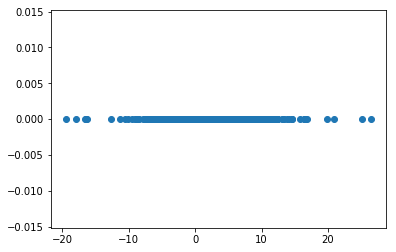

In [9]:
plt.scatter(x,np.zeros(n))

(array([  5.,   3.,  40., 978., 374., 520.,  63.,  13.,   2.,   2.]),
 array([-19.350635  , -14.77472417, -10.19881333,  -5.6229025 ,
         -1.04699166,   3.52891917,   8.10483001,  12.68074084,
         17.25665168,  21.83256251,  26.40847335]),
 <a list of 10 Patch objects>)

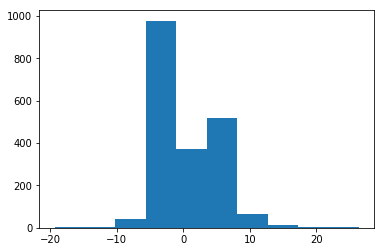

In [10]:
plt.hist(x)

(array([  1.,   2.,  10.,  98., 810.,  52.,   7.,   4.,   0.,   1.]),
 array([-12.64028027, -10.68447568,  -8.72867109,  -6.7728665 ,
         -4.81706191,  -2.86125732,  -0.90545273,   1.05035186,
          3.00615645,   4.96196104,   6.91776563]),
 <a list of 10 Patch objects>)

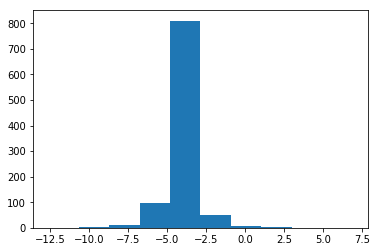

In [11]:
plt.hist(x[np.where(true_label_arg == 1)])

(array([  5.,   2.,  10.,  37., 362., 519.,  63.,  13.,   2.,   2.]),
 array([-19.350635  , -14.77472417, -10.19881333,  -5.6229025 ,
         -1.04699166,   3.52891917,   8.10483001,  12.68074084,
         17.25665168,  21.83256251,  26.40847335]),
 <a list of 10 Patch objects>)

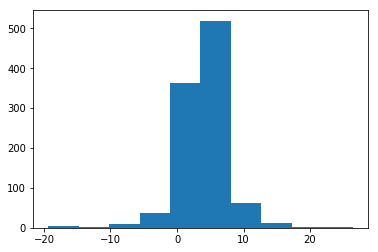

In [12]:
plt.hist(x[np.where(true_label_arg == 0)])

# 学習を行う

In [27]:
### 初期設定を行う
iteration = 1000
learning_seed = 20190515

## 学習モデルのコンポーネントの数
K = 4

## ハイパーパラメータ
pri_alpha = 0.1
pri_beta = 0.001
pri_gamma = 2
pri_delta = 2

np.random.seed(learning_seed)

energy = np.zeros(iteration)

In [28]:
### 初期値の設定
est_h_xi = np.random.gamma(shape = 1, size = (n, K))
est_u_xi = np.exp(est_h_xi) / np.repeat(np.exp(est_h_xi).sum(axis = 1), K).reshape(n,K)
est_u_xi = np.random.dirichlet(alpha = np.ones(K), size=n)

# est_alpha = np.random.gamma(shape = 10, size = K)
# est_beta = np.random.gamma(shape = 10, size = K)
# est_m = np.random.normal(scale = 3, size = K)
# est_gamma = np.random.gamma(shape = 10, size = K)
# est_delta = np.random.gamma(shape = 10, size = K)

est_g_eta = np.abs(np.random.normal(size=(n,K)))
est_v_eta = - est_u_xi * np.tanh(np.sqrt(est_g_eta)/2)/(4*np.sqrt(est_g_eta))

In [29]:
### 繰り返し計算部分
for ite in range(iteration):    
    ### 事後分布の更新
    est_alpha = pri_alpha + est_u_xi.sum(axis = 0)
    est_beta = pri_beta + (-2*est_v_eta.sum(axis = 0))
    est_m = (-2*x @ est_v_eta)/est_beta
    est_gamma = pri_gamma + est_u_xi.sum(axis = 0)/2
    est_delta = pri_delta - (x**2) @ est_v_eta - est_beta / 2 * est_m**2
    
    ### 対数双曲線関数の更新
    est_g_eta = est_gamma / est_delta * (np.repeat(x,K).reshape(n,K) - np.repeat(est_m,n).reshape(K,n).T)**2 + 1/est_beta
    est_v_eta = - est_u_xi * np.tanh(np.sqrt(est_g_eta)/2)/(4*np.sqrt(est_g_eta))
    
    ### 隠れ変数の更新
    est_h_xi = np.repeat(psi(est_alpha) - psi(est_alpha.sum()) + (psi(est_gamma) - np.log(est_delta))/2, n).reshape(K,n).T - np.log(np.cosh(np.sqrt(est_g_eta)/2))
    max_h_xi = est_h_xi.max(axis = 1)
    norm_h_xi = est_h_xi - np.repeat(max_h_xi,K).reshape(n,K)
    est_u_xi = np.exp(norm_h_xi) / np.repeat(np.exp(norm_h_xi).sum(axis = 1), K).reshape(n,K)        
    
    ### エネルギーの計算
    energy[ite] = (est_u_xi * np.log(np.cosh(np.sqrt(est_g_eta)/2))).sum() - (np.log(np.exp(norm_h_xi).sum(axis = 1)) + max_h_xi).sum() + (est_u_xi * est_h_xi + est_v_eta * est_g_eta).sum()
    energy[ite] += gammaln(est_alpha.sum()) - gammaln(K*pri_alpha) + (-gammaln(est_alpha) + gammaln(pri_alpha)).sum()
    energy[ite] += (np.log(est_beta/pri_beta)/2 + est_gamma * np.log(est_delta) - pri_gamma * np.log(pri_delta) - gammaln(est_gamma) + gammaln(pri_gamma)).sum()
#     print(energy[ite])
print(energy[-1])

1389.6406668342756


In [30]:
{
    "est_ratio": est_alpha / est_alpha.sum(),
    "est_b": est_m,
    "est_s": est_gamma / est_delta
}

{'est_ratio': array([4.99900020e-05, 4.76099687e-01, 1.02180171e-01, 4.21670152e-01]),
 'est_b': array([-5.23441378e-11, -4.00326590e+00,  2.40433407e+00,  4.15118412e+00]),
 'est_s': array([ 1.        , 17.19133568,  0.1783031 ,  1.51919728])}